In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# find scale parameters in all the data
country = 'Germany'

country_dict = {'Germany':['2002-05-01','2016-12-31'], 'Netherlands':['2000-01-01', '2015-09-10']}

inputs = pd.read_csv('../../../../data/'+country+'/input_data.csv').dropna()
inputs.rename(columns={ inputs.columns[0]: "time" }, inplace = True)
inputs = inputs.set_index('time')[country_dict[country][0]:country_dict[country][1]]

heads = pd.read_csv('../../../../data/'+country+'/heads.csv').dropna()
heads.rename(columns={ heads.columns[0]: "Date" }, inplace = True)
heads = heads.set_index('Date')[country_dict[country][0]:country_dict[country][1]]

dates = inputs.index
inputs = inputs.values
heads = heads.values

# add heads to input data
# inputs = np.append(inputs, heads, axis=1)

# make heads as diff
# heads = np.insert(np.diff(heads, axis=0), 0, 0, axis=0)

T = 90
D = inputs.shape[1]
N = len(inputs) - T
test_ratio = 0.2
train_ratio = 1 - test_ratio
Ntrain = int(N * train_ratio)

x_scaler = MinMaxScaler()
# x_scaler.fit(inputs[:Ntrain])
inputs = x_scaler.fit_transform(inputs)

y_scaler = MinMaxScaler()
# y_scaler.fit(heads[:Ntrain])
heads = y_scaler.fit_transform(heads)


# Building sample data
X = np.zeros((N, T, D))
y = np.zeros(N)

for t in range(N):
    X[t, : ,:] = inputs[t:t+T]
    y[t] = heads[t+T, 0]

y = np.expand_dims(y, axis=1)
val_ratio = test_ratio / (1 - test_ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

In [3]:
dataX = Variable(torch.Tensor(X))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(X_train).cuda())
trainY = Variable(torch.Tensor(y_train).cuda())

testX = Variable(torch.Tensor(X_test).cuda())
testY = Variable(torch.Tensor(y_test).cuda())

In [4]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [9]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
num_epochs = 1000
learning_rate = 0.01

hidden_size = 20
num_layers = 1
num_classes = 1

batch_size = trainX.shape[0]
n_batches = len(trainX) // batch_size

for i in range(1000):
    lstm = LSTM(num_classes, D, hidden_size, num_layers, T)
    lstm.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.001)
    # optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    loss_history, val_loss_history = [], []
    scheduler = StepLR(optimizer, step_size=300, gamma=0.7)

    for epoch in range(num_epochs):
        shufle_index = torch.randperm(trainX.size()[0])
        # shuffle_trainX, shuffle_trainY = trainX[shufle_index], trainY[shufle_index]
        shuffle_trainX, shuffle_trainY = trainX, trainY
        
        for batch in range(n_batches):
            batch_trainX, batch_trainY = shuffle_trainX[batch*batch_size:(batch+1)*batch_size,:,:], shuffle_trainY[batch*batch_size:(batch+1)*batch_size,:]

            outputs = lstm(batch_trainX)
            val_outputs = lstm(testX)
            optimizer.zero_grad()
            
            # obtain the loss function
            loss = criterion(outputs, batch_trainY)
            val_loss = criterion(val_outputs, testY)
            
            loss.backward()
            
            optimizer.step()

        loss_history.append(criterion(lstm(trainX), trainY).item())
        val_loss_history.append(val_loss.item())

        scheduler.step()
        if epoch % 100 == 0:
            print("try: %d,Epoch: %d, lr: %1.5f, loss: %1.5f, val_loss: %1.5f" % (i,epoch, scheduler.get_last_lr()[0], loss_history[-1], val_loss_history[-1]))

    torch.save(lstm, country+"_"+str(i)+'.pth')

try: 100,Epoch: 0, lr: 0.01000, loss: 0.02667, val_loss: 0.01015
try: 100,Epoch: 100, lr: 0.01000, loss: 0.00840, val_loss: 0.00583
try: 100,Epoch: 200, lr: 0.01000, loss: 0.00618, val_loss: 0.00452
try: 100,Epoch: 300, lr: 0.00700, loss: 0.00662, val_loss: 0.00428
try: 100,Epoch: 400, lr: 0.00700, loss: 0.00563, val_loss: 0.00411
try: 100,Epoch: 500, lr: 0.00700, loss: 0.00444, val_loss: 0.00428
try: 100,Epoch: 600, lr: 0.00490, loss: 0.00432, val_loss: 0.00467
try: 100,Epoch: 700, lr: 0.00490, loss: 0.00426, val_loss: 0.00481
try: 100,Epoch: 800, lr: 0.00490, loss: 0.00411, val_loss: 0.00479
try: 100,Epoch: 900, lr: 0.00343, loss: 0.00416, val_loss: 0.00471
try: 101,Epoch: 0, lr: 0.01000, loss: 0.02243, val_loss: 0.01500
try: 101,Epoch: 100, lr: 0.01000, loss: 0.00873, val_loss: 0.00530
try: 101,Epoch: 200, lr: 0.01000, loss: 0.00852, val_loss: 0.00446
try: 101,Epoch: 300, lr: 0.00700, loss: 0.00523, val_loss: 0.00479
try: 101,Epoch: 400, lr: 0.00700, loss: 0.00512, val_loss: 0.00449

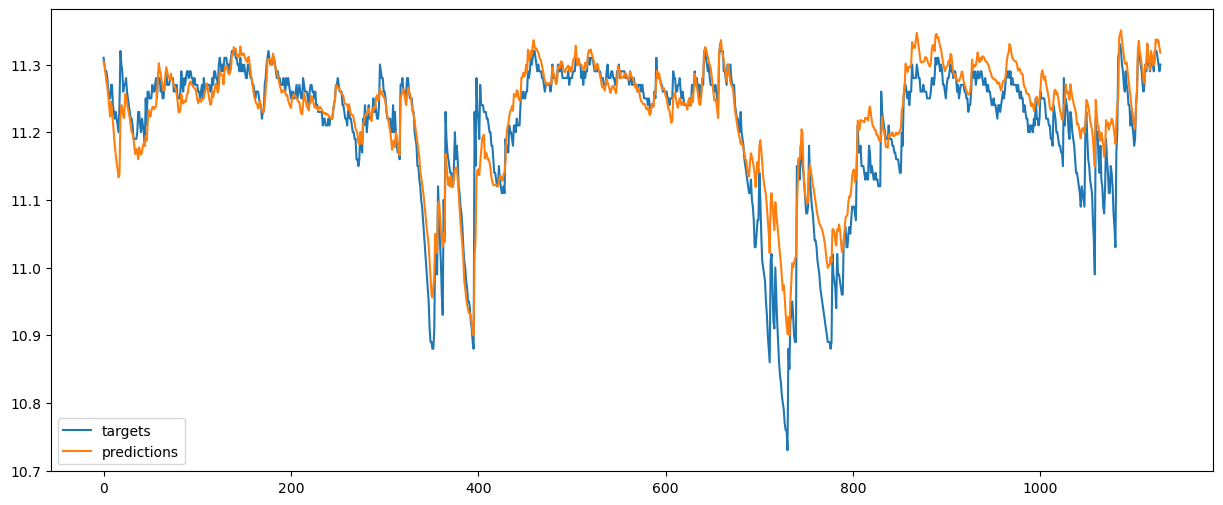

In [100]:
# one-step forcast for test data
lstm.eval()
outputs = lstm(testX)

plt.figure(figsize=(15, 6))
plt.plot(y_scaler.inverse_transform(testY.cpu().data.numpy()), label='targets')
plt.plot(y_scaler.inverse_transform(outputs.cpu().data.numpy()), label='predictions')
plt.legend()
plt.show()

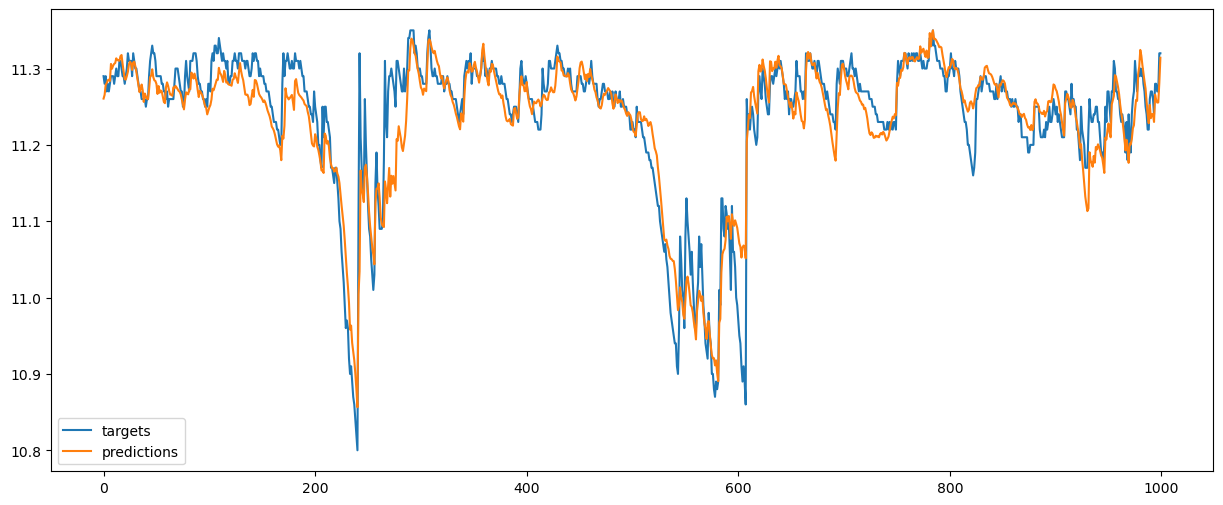

In [101]:
# one-step forcast for training data
outputs = lstm(trainX)

plt.figure(figsize=(15, 6))
plt.plot(y_scaler.inverse_transform(trainY.cpu().data.numpy())[-1000:], label='targets')
plt.plot(y_scaler.inverse_transform(outputs.cpu().data.numpy())[-1000:], label='predictions')
plt.legend()
plt.show()